In [2]:
import torch
from pykeops.torch import LazyTensor
import numpy as np
from torchvision.transforms import Resize as tv_resize
from PIL import Image
import time
from torch import nn
import math
import skimage.io as io
import os
import skimage.metrics as sm
from skimage.metrics import structural_similarity as ssim
import lpips
import torchvision
from OT_SUOT import OT,SUOT
from ROT_RSUOT_RUOT import RUOT

/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
import sys
  
# Prints the list of directories that the 
# interpreter will search for the required module. 
print(sys.path)

sys.path.insert(0, "/home/prof/smignon/ot_patch_denoising/Wasserstein_Patch_Prior/GitHub_SIAM")

['/home/prof/smignon/ot_patch_denoising/Wasserstein_Patch_Prior/GitHub_SIAM/Denoising_Experiments', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python37.zip', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/lib-dynload', '', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/site-packages', '/home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/site-packages/IPython/extensions', '/home/prof/smignon/.ipython']


### Functions for images 

In [4]:
def save_img(tensor_img, name):
	'''
	save img (tensor form) with the name
	'''
	img = np.clip(tensor_img.squeeze().detach().cpu().numpy(),0,1)
	io.imsave(str(name)+'.png', img)
	return     

def imread(img_name):
    '''
    loads an image as torch.tensor on the selected device
    '''
    np_img = io.imread(img_name)
    tens_img = torch.tensor(np_img, dtype=torch.float, device=DEVICE)
    if torch.max(tens_img) > 1:
        tens_img/=255 													
    if len(tens_img.shape) < 3:
        tens_img = tens_img.unsqueeze(2)						
    if tens_img.shape[2] > 3:										
        tens_img = tens_img[:,:,:3]
    tens_img = tens_img.permute(2,0,1)	
    return tens_img.unsqueeze(0)	

def show(im_deb,col=False):
    im_deb=im_deb.clone().detach()
    im_deb[im_deb>1]=1
    im_deb[im_deb<0]=0
    if col==True:
        im_deb=(255*im_deb.permute(1, 2, 0)).type(dtype=torch.uint8)
    else:
        im_deb=(255*im_deb).type(dtype=torch.uint8)
    imgpil = Image.fromarray(im_deb.numpy()) 
    display(imgpil)
    
class patch_extractor(nn.Module):
    '''
    Module for creating custom patch extractor
    '''
    def __init__(self, patch_size, pad=False,center=False):
        super(patch_extractor, self).__init__()
        self.im2pat = nn.Unfold(kernel_size=patch_size)
        self.pad = pad
        self.padsize = patch_size-1
        self.center=center
        self.patch_size=patch_size

    def forward(self, input, batch_size=0):
        if self.pad:
            input = torch.cat((input, input[:,:,:self.padsize,:]), 2)
            input = torch.cat((input, input[:,:,:,:self.padsize]), 3)
        patches = self.im2pat(input).squeeze(0).transpose(1,0)
        if batch_size > 0:
            idx = torch.randperm(patches.size(0))[:batch_size]
            patches = patches[idx,:]
        if self.center:
            patches = patches - torch.mean(patches,-1).unsqueeze(-1)
        return patches

def PSNR(im,im_new): 
    '''
    Compute PSNR
    '''
    M,N=im_new.shape
    EQM=1/(M*N)*torch.sum((im-im_new)**2)
    psnr=10*torch.log10(1/EQM)
    return(psnr)

loss_fn_alex = lpips.LPIPS(net='alex') # compute LPIPS

    
def Denoising(noisy_img,hr_img,function_OT,n_iter,lbd,lr=0.01,verbose=False,patch_size=6):
    '''
    Denoising via gradient descent
    '''
    # patchs exctractors
    target_im2pat = patch_extractor(patch_size, pad=False,center=False)
    input_im2pat = patch_extractor(patch_size, pad=False,center=False)
    
    # load y patches
    y= hr_img.clone()
    nuY = target_im2pat(y, -1).contiguous()
    
    # load x
    x=noisy_img.clone()
    _,_,N,M=x.shape
    x.requires_grad = True
    
    # optimizer 
    optimizer = torch.optim.Adam([x], lr=lr)
    
    # g_init 
    g_i=None
    
    # Temps de calcul 
    torch.cuda.synchronize()
    t = time.time()
    for i in range(n_iter):
        # Zero the gradients
        optimizer.zero_grad()
        
        # Exctract x patches 
        nuX = input_im2pat(x, -1).contiguous()
        
        # Compute loss
        AD_cost = lbd*(patch_size**2/(N*M))*torch.sum((x-noisy_img)**2)
        OT_cost,g_i = function_OT(nuX,nuY,g_i)
        #OT_cost,_ = function_OT(nuX,nuY,g_i)
        Total_cost= AD_cost + OT_cost
        
        if verbose==True:
            print('n=',i,', OT: ',OT_cost.clone().item(),', TC: ',Total_cost.clone().item(),', AD: ',AD_cost.clone().item() )
        
        # Compute the gradient
        Total_cost.backward()
        
        # Update x
        optimizer.step()
    
    # Computation time 
    torch.cuda.synchronize()
    temps=int(time.time()-t)
    print('DONE - total time is '+str(temps)+'s')
    
    return x,temps

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/prof/smignon/anaconda3/envs/WPP_color/lib/python3.7/site-packages/lpips/weights/v0.1/alex.pth


### Denoising with SUOT

DONE - total time is 326s
Noisy:


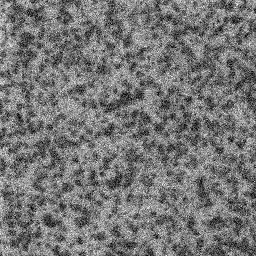

HR:


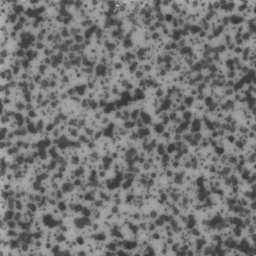

Denoised:


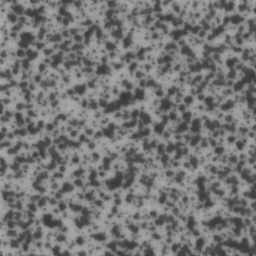

Reference:


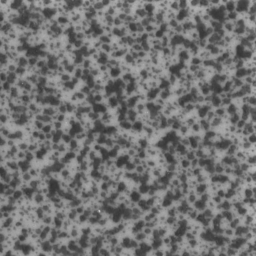

In [17]:
torch.cuda.set_device(2)
DEVICE='cuda'

# Load images 
hr_img=imread('HR_tile.png')
noisy_img=imread('Noisy_tile.png')
ref_img=imread('REF_tile.png')

# Define SUOT
def SU_OT(x,y,g_init):
    return(SUOT(x,y,g_init=g_init,nb_it=10,ρ=0.01,dev="cuda",lr=50))

resulting_img,temps=Denoising(noisy_img=noisy_img,hr_img=ref_img,function_OT=SU_OT,lbd=0.0329,n_iter=500,verbose=False,patch_size=6,lr=0.001)

# Results
print("Noisy:")
show(noisy_img.squeeze().to('cpu'),col=False)

print("HR:")
show(hr_img.squeeze().to('cpu'),col=False)

print("Denoised:")
show(resulting_img.detach().squeeze().to('cpu'),col=False)

print("Reference:")
show(ref_img.squeeze().to('cpu'),col=False)

In [18]:
# PSNR
print("PSNR = ",PSNR(torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12),
                           torchvision.transforms.functional.crop(resulting_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12)).item())
# LPIPS
print("LPIPS = ",loss_fn_alex(torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).unsqueeze(0).unsqueeze(0)
                                  , torchvision.transforms.functional.crop(resulting_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).unsqueeze(0).unsqueeze(0)))

# SSIM:
img_hr=torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).detach().numpy()
img_pred_E=torchvision.transforms.functional.crop(resulting_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).detach().numpy()
print("SSIM = ",ssim(img_hr, img_pred_E,data_range=img_pred_E.max() - img_pred_E.min()))

PSNR =  27.144245147705078
LPIPS =  tensor([[[[0.0675]]]], grad_fn=<AddBackward0>)
SSIM =  0.8112626879705007


### Denoising with OT

DONE - total time is 326s
Noisy:


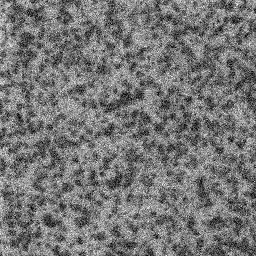

HR:


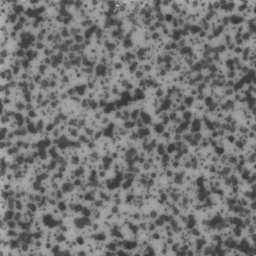

Denoised:


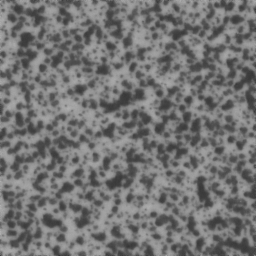

Reference:


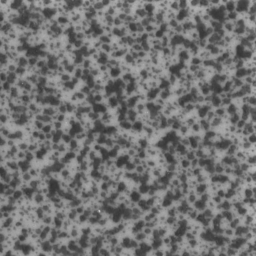

In [19]:
# Load images 
hr_img=imread('HR_tile.png')
noisy_img=imread('Noisy_tile.png')
ref_img=imread('REF_tile.png')

# Define OT
def B_OT(x,y,g_init):
    return(OT(x,y,g_init=None,nb_it=10,dev="cuda",lr=200))

resulting_img,temps=Denoising(noisy_img=noisy_img,hr_img=ref_img,function_OT=B_OT,lbd=0.0329,n_iter=500,verbose=False,patch_size=6,lr=0.01)

# Results
print("Noisy:")
show(noisy_img.squeeze().to('cpu'),col=False)

print("HR:")
show(hr_img.squeeze().to('cpu'),col=False)

print("Denoised:")
show(resulting_img.detach().squeeze().to('cpu'),col=False)

print("Reference:")
show(ref_img.squeeze().to('cpu'),col=False)

In [20]:
# PSNR
print("PSNR = ",PSNR(torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12),
                           torchvision.transforms.functional.crop(resulting_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12)).item())
# LPIPS
print("LPIPS = ",loss_fn_alex(torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).unsqueeze(0).unsqueeze(0)
                                  , torchvision.transforms.functional.crop(resulting_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).unsqueeze(0).unsqueeze(0)))

# SSIM:
img_hr=torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).detach().numpy()
img_pred_E=torchvision.transforms.functional.crop(resulting_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).detach().numpy()
print("SSIM = ",ssim(img_hr, img_pred_E,data_range=img_pred_E.max() - img_pred_E.min()))

PSNR =  26.421764373779297
LPIPS =  tensor([[[[0.0783]]]], grad_fn=<AddBackward0>)
SSIM =  0.7874931178319345


### Denoising with RUOT

n= 0 , OT:  0.040061354637145996 , TC:  0.040061354637145996 , AD:  0.0
n= 1 , OT:  0.040018245577812195 , TC:  0.040042679756879807 , AD:  2.4433231374132447e-05
n= 2 , OT:  0.04000663012266159 , TC:  0.040026869624853134 , AD:  2.0241324818925932e-05
n= 3 , OT:  0.039980869740247726 , TC:  0.04000484570860863 , AD:  2.397487151029054e-05
n= 4 , OT:  0.039933525025844574 , TC:  0.03996531665325165 , AD:  3.179227132932283e-05
n= 5 , OT:  0.03986312448978424 , TC:  0.039905332028865814 , AD:  4.220746995997615e-05
n= 6 , OT:  0.03977300599217415 , TC:  0.039834074676036835 , AD:  6.106778891989961e-05
n= 7 , OT:  0.039665624499320984 , TC:  0.0397532694041729 , AD:  8.764329686528072e-05
n= 8 , OT:  0.03954078257083893 , TC:  0.03965647891163826 , AD:  0.00011569454363780096
n= 9 , OT:  0.03939555585384369 , TC:  0.03954102843999863 , AD:  0.00014547437604051083
n= 10 , OT:  0.03922698646783829 , TC:  0.03940913826227188 , AD:  0.00018215086311101913
n= 11 , OT:  0.039035238325595856 ,

n= 92 , OT:  0.03020324371755123 , TC:  0.03353159874677658 , AD:  0.0033283536322414875
n= 93 , OT:  0.03017709031701088 , TC:  0.03353317454457283 , AD:  0.003356085391715169
n= 94 , OT:  0.030158910900354385 , TC:  0.03354167565703392 , AD:  0.003382765455171466
n= 95 , OT:  0.030140072107315063 , TC:  0.03354942053556442 , AD:  0.003409348661080003
n= 96 , OT:  0.03010227158665657 , TC:  0.03353937715291977 , AD:  0.003437104867771268
n= 97 , OT:  0.03006097674369812 , TC:  0.0335267037153244 , AD:  0.0034657251089811325
n= 98 , OT:  0.03003280609846115 , TC:  0.03352661058306694 , AD:  0.003493804018944502
n= 99 , OT:  0.03000817261636257 , TC:  0.03352932259440422 , AD:  0.003521150443702936
n= 100 , OT:  0.02996876649558544 , TC:  0.033516258001327515 , AD:  0.0035474926698952913
n= 101 , OT:  0.029913201928138733 , TC:  0.033486731350421906 , AD:  0.003573529189452529
n= 102 , OT:  0.029866913333535194 , TC:  0.03346572443842888 , AD:  0.003598812036216259
n= 103 , OT:  0.02983

n= 184 , OT:  0.026960138231515884 , TC:  0.03226689249277115 , AD:  0.005306752864271402
n= 185 , OT:  0.026936601847410202 , TC:  0.03226085752248764 , AD:  0.005324254743754864
n= 186 , OT:  0.026921318843960762 , TC:  0.03226000443100929 , AD:  0.005338685121387243
n= 187 , OT:  0.02691691555082798 , TC:  0.032268863171339035 , AD:  0.005351948086172342
n= 188 , OT:  0.026904430240392685 , TC:  0.032269299030303955 , AD:  0.005364870652556419
n= 189 , OT:  0.026879634708166122 , TC:  0.03225699067115784 , AD:  0.005377356894314289
n= 190 , OT:  0.026843620464205742 , TC:  0.032234255224466324 , AD:  0.005390635691583157
n= 191 , OT:  0.026791328564286232 , TC:  0.032195668667554855 , AD:  0.005404338706284761
n= 192 , OT:  0.026743195950984955 , TC:  0.03216122090816498 , AD:  0.005418026819825172
n= 193 , OT:  0.02672237902879715 , TC:  0.03215540200471878 , AD:  0.00543302483856678
n= 194 , OT:  0.026713360100984573 , TC:  0.0321614146232605 , AD:  0.005448054056614637
n= 195 , O

n= 276 , OT:  0.024887870997190475 , TC:  0.031484030187129974 , AD:  0.006596158258616924
n= 277 , OT:  0.02487519010901451 , TC:  0.03148317709565163 , AD:  0.006607988383620977
n= 278 , OT:  0.0248618945479393 , TC:  0.03148188441991806 , AD:  0.006619990803301334
n= 279 , OT:  0.024860914796590805 , TC:  0.03149290010333061 , AD:  0.0066319843754172325
n= 280 , OT:  0.02485436201095581 , TC:  0.03149944543838501 , AD:  0.006645082030445337
n= 281 , OT:  0.02482577972114086 , TC:  0.031488046050071716 , AD:  0.006662268191576004
n= 282 , OT:  0.024787088856101036 , TC:  0.03146978095173836 , AD:  0.0066826920956373215
n= 283 , OT:  0.024739736691117287 , TC:  0.03144356608390808 , AD:  0.006703830789774656
n= 284 , OT:  0.024707941338419914 , TC:  0.03143013268709183 , AD:  0.006722191348671913
n= 285 , OT:  0.024698644876480103 , TC:  0.03143457695841789 , AD:  0.006735930684953928
n= 286 , OT:  0.02469651587307453 , TC:  0.03144326061010361 , AD:  0.006746746599674225
n= 287 , OT:

n= 368 , OT:  0.023489465937018394 , TC:  0.031011482700705528 , AD:  0.007522016763687134
n= 369 , OT:  0.02349143661558628 , TC:  0.031019601970911026 , AD:  0.00752816628664732
n= 370 , OT:  0.023548338562250137 , TC:  0.031079966574907303 , AD:  0.00753162894397974
n= 371 , OT:  0.023579325526952744 , TC:  0.031114138662815094 , AD:  0.007534812204539776
n= 372 , OT:  0.023591024801135063 , TC:  0.03113025799393654 , AD:  0.0075392331928014755
n= 373 , OT:  0.023592688143253326 , TC:  0.031139157712459564 , AD:  0.007546469569206238
n= 374 , OT:  0.023585565388202667 , TC:  0.031142786145210266 , AD:  0.007557220757007599
n= 375 , OT:  0.023581303656101227 , TC:  0.031150689348578453 , AD:  0.0075693861581385136
n= 376 , OT:  0.02357163280248642 , TC:  0.031153123825788498 , AD:  0.007581491954624653
n= 377 , OT:  0.0235501267015934 , TC:  0.031143762171268463 , AD:  0.007593635004013777
n= 378 , OT:  0.023524463176727295 , TC:  0.031130604445934296 , AD:  0.007606141734868288
n= 3

n= 459 , OT:  0.02274422161281109 , TC:  0.030893392860889435 , AD:  0.008149171248078346
n= 460 , OT:  0.022730372846126556 , TC:  0.03089052438735962 , AD:  0.008160152472555637
n= 461 , OT:  0.02271999791264534 , TC:  0.03088878095149994 , AD:  0.008168782107532024
n= 462 , OT:  0.02271050587296486 , TC:  0.030884331092238426 , AD:  0.008173825219273567
n= 463 , OT:  0.022702379152178764 , TC:  0.030879070982336998 , AD:  0.008176691830158234
n= 464 , OT:  0.022685512900352478 , TC:  0.030865374952554703 , AD:  0.008179862052202225
n= 465 , OT:  0.022658605128526688 , TC:  0.030842091888189316 , AD:  0.008183487690985203
n= 466 , OT:  0.022631511092185974 , TC:  0.030818462371826172 , AD:  0.008186952210962772
n= 467 , OT:  0.022603053599596024 , TC:  0.03079225867986679 , AD:  0.008189204148948193
n= 468 , OT:  0.02258342131972313 , TC:  0.030773356556892395 , AD:  0.008189934305846691
n= 469 , OT:  0.022560633718967438 , TC:  0.03075045347213745 , AD:  0.008189820684492588
n= 470 

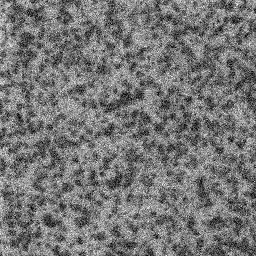

HR:


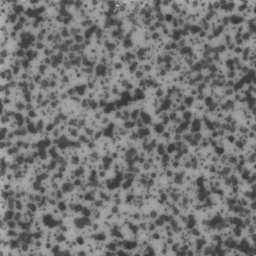

Denoised:


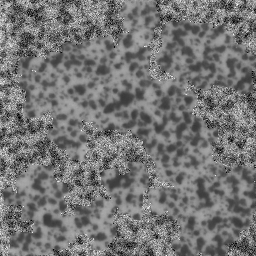

Reference:


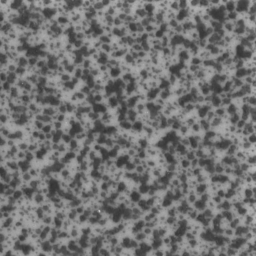

In [8]:
torch.cuda.set_device(2)
DEVICE='cuda'

# Load images 
hr_img=imread('HR_tile.png')
noisy_img=imread('Noisy_tile.png')
ref_img=imread('REF_tile.png')

# Define RUOT
def RU_OT(x,y,fg_init):
    return(RUOT(x,y,ε=1e-4,ρ=0.02,fg_init=fg_init,nb_it=10,dev=DEVICE))

resulting_img,temps=Denoising(noisy_img=noisy_img,hr_img=ref_img,function_OT=RU_OT,lbd=0.0329,n_iter=500,verbose=True,patch_size=6,lr=0.01)

# Results
print("Noisy:")
show(noisy_img.squeeze().to('cpu'),col=False)

print("HR:")
show(hr_img.squeeze().to('cpu'),col=False)

print("Denoised:")
show(resulting_img.detach().squeeze().to('cpu'),col=False)

print("Reference:")
show(ref_img.squeeze().to('cpu'),col=False)

In [9]:
# PSNR
print("PSNR = ",PSNR(torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12),
                           torchvision.transforms.functional.crop(resulting_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12)).item())
# LPIPS
print("LPIPS = ",loss_fn_alex(torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).unsqueeze(0).unsqueeze(0)
                                  , torchvision.transforms.functional.crop(resulting_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).unsqueeze(0).unsqueeze(0)))

# SSIM:
img_hr=torchvision.transforms.functional.crop(hr_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).detach().numpy()
img_pred_E=torchvision.transforms.functional.crop(resulting_img.squeeze().to('cpu'),top=6,left=6,height=256-12,width=256-12).detach().numpy()
print("SSIM = ",ssim(img_hr, img_pred_E,data_range=img_pred_E.max() - img_pred_E.min()))

PSNR =  21.34096908569336
LPIPS =  tensor([[[[0.4083]]]], grad_fn=<AddBackward0>)
SSIM =  0.6353857504974414
